In [1]:
from pyiron_feal import Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
pr = Project('projects/research')

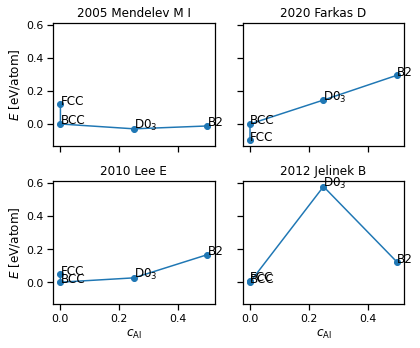

In [21]:
n_potls = len(pr.input.potentials)
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(6,5))

for potl_index, potl_name in enumerate(pr.input.potentials):
    ax = pr.zerok.plot_phases_0K(
        potl_index=potl_index, 
        ax=axes.flatten()[potl_index],
        label_x=potl_index in [2, 3],
        label_y=potl_index in [0, 2]
    )
    ax.set_title(pr.lammps_potl_to_string(potl_name))
fig.tight_layout()
fig.savefig('writeup/supplementary/figures/zerok_phases.pdf', format='pdf')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

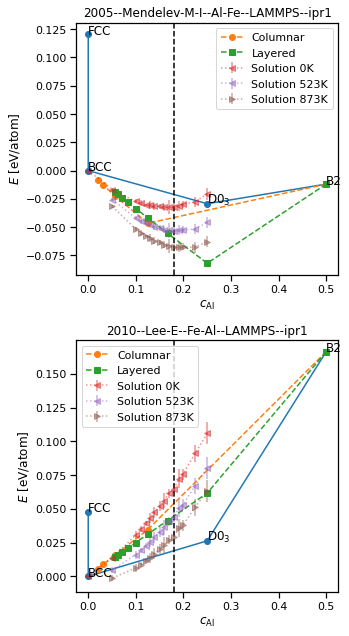

In [293]:
# Columnar
reps = np.arange(1, 6, dtype=int)
columnar_c_Al = [1 / len(pr.create.structure.FeAl.columnar_b2(planar_repeats=r)) for r in reps]  # 1 / (2 * reps**2)

# Layered
layers = np.arange(1, 10, dtype=int)
layered_c_Al = [1 / len(pr.create.structure.FeAl.layered_Al(layers=l)) for l in layers]

# Solid solution
c_Al_targets = np.unique(np.concatenate((
    np.linspace(0, 0.1, 3),
    np.linspace(0.1, 0.2, 11),
    np.linspace(0.2, 0.25, 3)
)))
deg = 3
c_range = np.linspace(0, 0.25, 200)

fig, axes = plt.subplots(nrows=2, figsize=(5, 9))
for potl_index, ax in zip([0, 2], axes):
    e_ref =  pr.zerok.get_bcc_peratom_energy(potl_index=potl_index)
    
    columnar_energy = np.array([
        pr.zerok.get_columnar_b2_peratom_energy(planar_repeats=r, potl_index=potl_index) 
        for r in reps
    ]) - e_ref
    
    layered_energy = np.array([
        pr.zerok.get_layered_peratom_energy(layers=l, potl_index=potl_index) 
        for l in layers
    ]) - e_ref
    
    concentrations, solution_energies = pr.zerok.get_bcc_solution_energies(
        c_Al_targets, 
        repeat=3, 
        n_trials=10,
        potl_index=potl_index
    )
    means, stds = solution_energies.mean(axis=-1) - e_ref, solution_energies.std(axis=-1)
    S = pr.zerok.S_ideal_mixing(c_Al_targets)
    poly = np.poly1d(np.polyfit(concentrations, means, deg=deg))
    
    ax = pr.zerok.plot_phases_0K(
        relative=True, 
        potl_index=potl_index,
        ax=ax
    )
    ax.plot(columnar_c_Al, columnar_energy, label='Columnar', marker='o', linestyle='--')
    ax.plot(layered_c_Al, layered_energy, label='Layered', marker='s', linestyle='--')
    ax.errorbar(
        concentrations,
        means,
        yerr=1.96*stds,  # std -> 95% confidence interval
        marker='<',
        linestyle=':',
        alpha=0.5,
        label='Solution 0K'
    )
    ax.errorbar(
        concentrations,
        means -523*S,
        yerr=1.96*stds,  # std -> 95% confidence interval
        marker='<',
        linestyle=':',
        alpha=0.5,
        label='Solution 523K'
    )
    ax.errorbar(
        concentrations,
        means -873*S,
        yerr=1.96*stds,  # std -> 95% confidence interval
        marker='>',
        linestyle=':',
        alpha=0.5,
        label='Solution 873K'
    )
    ax.axvline(0.18, color='k', linestyle='--')
    ax.set_title(pr.input.potentials[potl_index])
    ax.legend()
fig.tight_layout()
fig.savefig(
    'writeup/supplementary/figures/expanded_0K_phases.eps', 
    format='eps'
)    
plt.show();

In [27]:
solid_solution_size = len(pr.inspect('min_p2_bcc_r3_t4_P0_cAl5_09')['output/generic/positions'][-1])
solid_solution_size

432

In [44]:
pr.create.structure.FeAl.fcc().plot3d(view_plane=[1, 1, 1])

NGLWidget()

In [60]:
pr.create.structure.FeAl.bcc(repeat=3, c_Al=0.18).plot3d()

NGLWidget()

In [61]:
pr.create.structure.FeAl.d03().plot3d()

NGLWidget()

In [62]:
pr.create.structure.FeAl.b2().plot3d()

NGLWidget()

In [63]:
pr.create.structure.FeAl.columnar_b2(planar_repeats=3).repeat(2).plot3d()

NGLWidget()

In [64]:
pr.create.structure.FeAl.layered_Al(layers=3).repeat(3).plot3d()

NGLWidget()

In [303]:
mcmd_jobs = {}
for T in [523, 873]:
    for potl, run_time in zip([0, 2], [86400, 345599]):
        job = pr.create.job.mcmd.small_cube(
            temperature=T, 
            potl_index=potl,
            n_ionic_steps=1e5,
            n_print=1e4
        )
        job.server.queue = 'cm'
        job.run()
        mcmd_jobs[f'potl{potl}_{T}K'] = job

2021-09-03 22:39:15,403 - pyiron_log - WARNING - The job mcmd_p0_cube_523K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-09-03 22:39:16,229 - pyiron_log - WARNING - The job mcmd_p2_cube_523K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-09-03 22:39:17,093 - pyiron_log - WARNING - The job mcmd_p0_cube_873K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2021-09-03 22:39:17,933 - pyiron_log - WARNING - The job mcmd_p2_cube_873K_cAl18_0_mu0_n100000_k10000 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [302]:
mcmd_jobs.keys()

dict_keys(['potl0_523K', 'potl2_523K', 'potl0_873K', 'potl2_873K'])

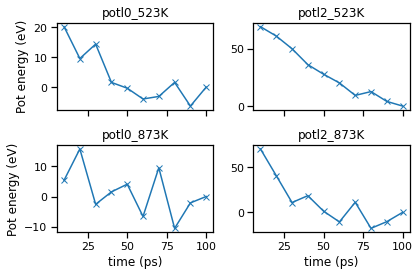

In [312]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True)
for ax, (name, job) in zip(axes.flatten(), mcmd_jobs.items()):
    time = (1 + np.arange(len(job.output.energy_pot[1:]))) * 10  # ps
    ax.plot(time, job.output.energy_pot[1:] - job.output.energy_pot[-1], marker='x')
    ax.set_title(name)
axes[1, 0].set_xlabel('time (ps)')
axes[1, 1].set_xlabel('time (ps)')
axes[0, 0].set_ylabel('Pot energy (eV)') 
axes[1, 0].set_ylabel('Pot energy (eV)') 
fig.tight_layout()
fig.savefig(
    'writeup/supplementary/figures/energy_conv.eps', 
    format='eps'
)
plt.show()

In [74]:
pr.mcmd_sro.remap_species(mcmd_jobs['potl0_523K']).plot3d()

NGLWidget()

In [75]:
pr.mcmd_sro.remap_species(mcmd_jobs['potl0_873K']).plot3d()

NGLWidget()

In [76]:
pr.mcmd_sro.remap_species(mcmd_jobs['potl2_523K']).plot3d()

NGLWidget()

In [77]:
pr.mcmd_sro.remap_species(mcmd_jobs['potl2_873K']).plot3d()

NGLWidget()

In [81]:
n_neigh = 14  # 8=1NN, 14=1+2NN
topology = mcmd_jobs['potl0_523K'].get_structure(0).get_neighbors(num_neighbors=n_neigh).indices
reference_environments = {
    ref: getattr(pr.mcmd_sro.reference_symbols.small_cube, ref)
    for ref in ['b2_0', 'b2_1', 'd03_0', 'd03_1', 'd03_2', 'd03_3']
}  # TODO: Better code between the attribute and the next method call
pr.mcmd_sro.define_clustering(
    topology=topology, 
    reference_environments=reference_environments, 
    threshold=11
)

In [140]:
jobs = {
    'Mendelev 523K': men_cold,
    'Mendelev 873K': men_hot,
    'Lee 523K': lee_cold,
    'Lee 873K': lee_hot,
}

In [150]:
clusters = {}
for threshold in [11, 12, 13]:
    clusters[threshold] = {}
    for name, job in mcmd_jobs.items():
        clusters[threshold][name] = {}
        clusters[threshold][name]['before'] = pr.mcmd_sro.cluster(
            job.get_structure(0).get_chemical_symbols(), 
            threshold=threshold
        )
        clusters[threshold][name]['after'] = pr.mcmd_sro.cluster(
            job.get_structure(-1).get_chemical_symbols(), 
            threshold=threshold
        )

In [283]:
def clipit(data, clip):
    return np.clip(data, 0, clip) if clip is not None else data

def plot_hist(ax, cluster, phase, clip=None, title=None):
    before = clipit(getattr(cluster['before'], phase), clip)
    after = clipit(getattr(cluster['after'], phase), clip)
    biggest = np.amax(np.append(before, after))
    ax.hist(
        [before, after], 
        bins=np.arange(biggest + binsize, step=binsize), 
        label=['before', 'after']
    )
    ax.set_yscale('log')
    ax.set_title(title)
    return ax

def plot_histograms(potl_index, threshold=13, binsize=10, clip=160):
    fig, axes = plt.subplots(
        ncols=2, 
        nrows=2, 
        sharey='col', 
        sharex='col'
    )


    plot_hist(
        axes[0, 0],
        clusters[threshold][f'potl{potl_index}_523K'],
        'd03', clip=clip, #title='cold d03'
    )
    plot_hist(
        axes[0, 1],
        clusters[threshold][f'potl{potl_index}_523K'],
        'b2', clip=clip, #title='cold b2'
    )
    plot_hist(
        axes[1, 0],
        clusters[threshold][f'potl{potl_index}_873K'],
        'd03', clip=clip, #title='hot d03'
    )
    plot_hist(
        axes[1, 1],
        clusters[threshold][f'potl{potl_index}_873K'],
        'b2', clip=clip, #title='hot b2'
    )
    axes[0, 0].set_ylabel('523 K counts')
    axes[1, 0].set_ylabel('873 K counts')
    axes[1, 0].set_xlabel('D$0_3$ cluster size')
    axes[1, 1].set_xlabel('B2 cluster size')
    axes[0, 1].legend(loc='upper right')
    fig.tight_layout()
    return fig, axes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


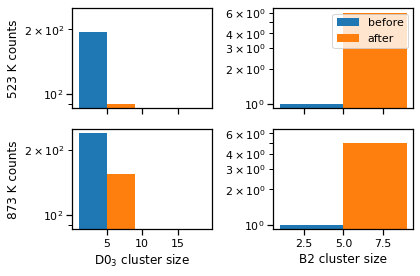

In [284]:
plot_histograms(0);  # Mendelev
fig.savefig(
    'writeup/supplementary/figures/mendelev_hist_thresh13.eps', 
    format='eps'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


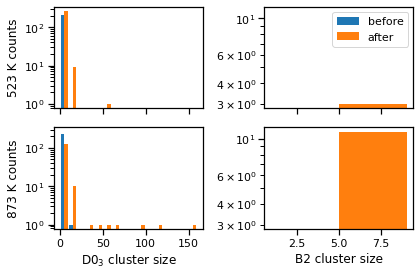

In [285]:
fig, axes = plot_histograms(2);  # Lee
fig.savefig(
    'writeup/supplementary/figures/lee_hist_thresh13.eps', 
    format='eps'
)

In [271]:
def _flat_ids(cluster, phase, i_list):
    try:
        return np.unique(
            np.concatenate([
                np.concatenate(cluster[f'{phase}_{i}'])
                for i in i_list
            ])
        )
    except ValueError:
        return []

def flat_d03_ids(cluster):
    return _flat_ids(cluster, 'd03', [0, 1, 2, 3])

def flat_b2_ids(cluster):
    return _flat_ids(cluster, 'b2', [0, 1])

def _chemistry_fractions(species):
    if len(species) < 1: 
        return None
    n = len(species)
    n_Al = np.sum(species == 'Al')
    return n_Al / n

def get_cluster_chemistry(cluster, job, frame=-1, threshold=12):
    species = job.get_structure(frame=frame).get_chemical_symbols()
    d03_ids = flat_d03_ids(cluster)
    b2_ids = flat_b2_ids(cluster)
    return (
        _chemistry_fractions(species[d03_ids]), 
        _chemistry_fractions(species[b2_ids])
    )

In [272]:
threshold = 13
hot_mendelev_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['potl0_873K']['after'], 
    jobs['Mendelev 873K']
)
print(hot_mendelev_Al_fractions)
hot_lee_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['potl2_873K']['after'], 
    jobs['Lee 873K']
)
print(hot_lee_Al_fractions)
cold_lee_Al_fractions = get_cluster_chemistry(
    clusters[threshold]['potl2_523K']['after'], 
    jobs['Lee 523K']
)
print(cold_lee_Al_fractions)
# Hot Lee is much closer to the nominal compositions of 25 and 50% Al

(0.8877551020408163, None)
(0.4814453125, 0.9166666666666666)
(0.697324414715719, 1.0)


In [273]:
# Picking up that planar structure in Mendelev
a_job = jobs['Mendelev 523K']
a_cluster = clusters[11]['potl0_523K']['after']['b2_1']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [279]:
# In contrast, what does Lee show at the same conditions?
a_job = jobs['Lee 523K']
a_cluster = clusters[11]['potl2_523K']['after']['b2_0']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [315]:
# Mendelev is showing D03?! Not at strictness 13 it's not
a_job = jobs['Mendelev 873K']
a_cluster = clusters[13]['potl0_873K']['after']['d03_3']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [316]:
# Biggest cluster for hot Lee
a_job = jobs['Lee 873K']
a_cluster = clusters[13]['potl2_873K']['after']['d03_2']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [317]:
# Not so big for cold Lee
a_job = jobs['Lee 523K']
a_cluster = clusters[13]['potl2_523K']['after']['d03_3']
biggest_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]
pr.mcmd_sro.remap_species(a_job)[biggest_cluster].plot3d()

NGLWidget()

In [135]:

a_cluster = a_cluster[np.argmax([len(c) for c in a_cluster])]


a_struct[a_cluster].repeat(2).plot3d()

TODO:
- Save job dict more sensibly
- Separate calculation of clusters from plotting 
- Finalize some half decent plots (which threshold to use?)
- Plot biggest clusters
- Put it all in the writeup 
- Send the writeup around
- Do more temperatures for Lee? Or numerical analysis for Lee?